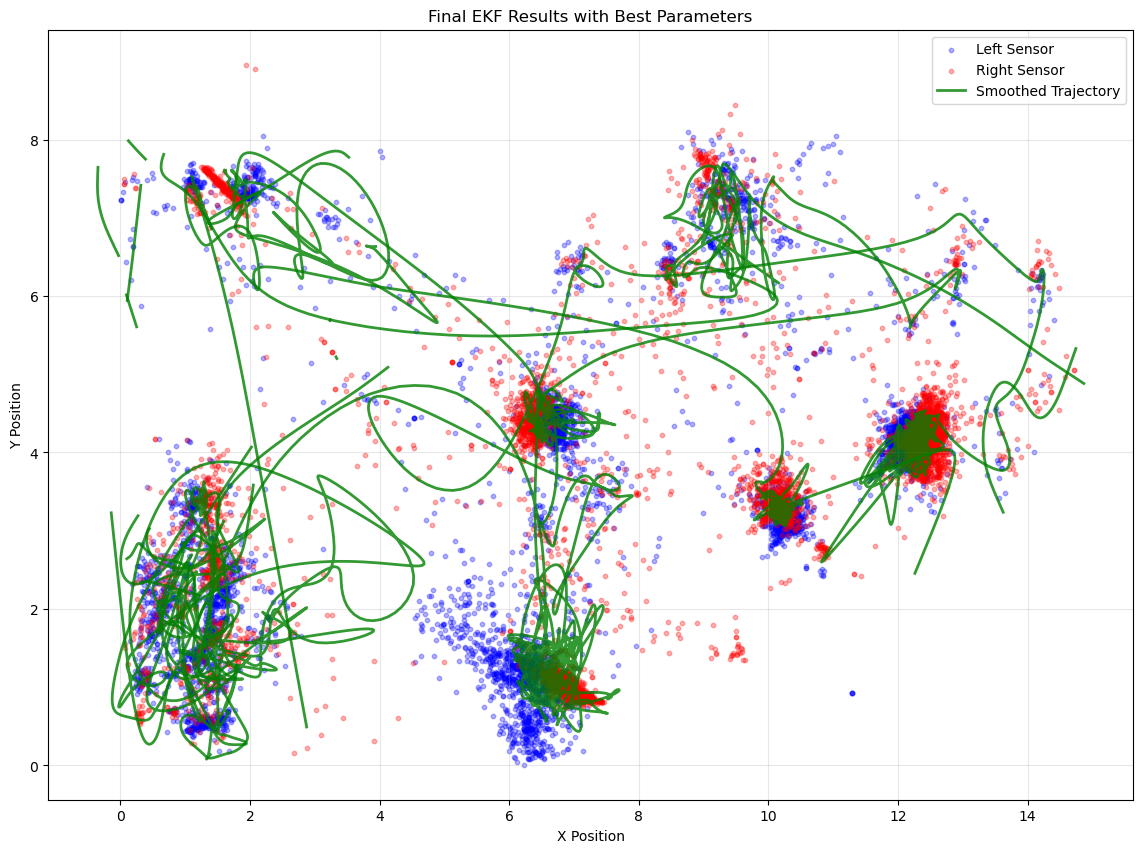

In [1]:
import numpy as np
import pandas as pd
import os
from scipy.linalg import block_diag
from scipy.optimize import minimize
from sklearn.model_selection import KFold
import itertools
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import clear_output
import time

from data_processing_13_part3_ekf import compute_smoothed_trajectory, ekf_forward, smoother

In [2]:
file_path = './Synched_Data_GR0_22_DEN_MAXZ1_25/NEWDATA/'
file_date = ['101922', '102122', '111422', '111622', '120522', '120722', '013023', '020123', '031323', '031523', '041723', '041923', '061523']
date = file_date[0]

file_name = f'DAYUBIGR_{date}_GR0_22_DEN_032825_V2392628911.CSV'
full_path = file_path + file_name

raw_data = pd.read_csv(full_path, header=None, names=['SUBJECTID', 'TIME', 'X', 'Y', 'Z'])
clear_data = raw_data.reset_index(drop=True)
clear_data = clear_data[(clear_data["X"] <= 15) & (clear_data["Y"] <= 9) & 
                        (clear_data["X"] >= 0) & (clear_data["Y"] >= 0)].copy()
target_subject_base = "DS_STARFISH_2223_27"
subject_data = clear_data[clear_data['SUBJECTID'].str.startswith(target_subject_base)].copy()
subject_data['side'] = subject_data['SUBJECTID'].str.extract(r'(\d+[LR])$')[0].str[-1].map({'L': 'left', 'R': 'right'})


In [ ]:
# The chart has both right and left side data points
def create_jupyter_animation(subject_data):
    
    data_sorted = subject_data.sort_values('TIME').reset_index(drop=True)
    step = 1
    
    for i in range(0, len(data_sorted), step):
        clear_output(wait=True)
        
        current_data = data_sorted.iloc[:i+1]
        
        plt.figure(figsize=(14, 10))
        left_data = current_data[current_data['side'] == 'left']
        right_data = current_data[current_data['side'] == 'right']
        
        if len(left_data) > 0:
            plt.scatter(left_data['X'], left_data['Y'], c='red', s=50, alpha=0.5, label='Left Side')
        
        if len(right_data) > 0:
            plt.scatter(right_data['X'], right_data['Y'], c='blue', s=50, alpha=0.5, label='Right Side')
        
        if i < len(data_sorted):
            current_point = data_sorted.iloc[i]
            color = 'red' if current_point['side'] == 'left' else 'blue'
            plt.scatter(current_point['X'], current_point['Y'], c=color, s=100, alpha=1.0, 
                       edgecolors='black', linewidth=2, marker='o')
        
        plt.xlim(0, 15)
        plt.ylim(0, 9)
        plt.xlabel('X Position')
        plt.ylabel('Y Position')
        plt.title(f'Starfish Movement - Point {i+1}/{len(data_sorted)}')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.show()
        time.sleep(0.05)

create_jupyter_animation(subject_data)

KeyboardInterrupt: 

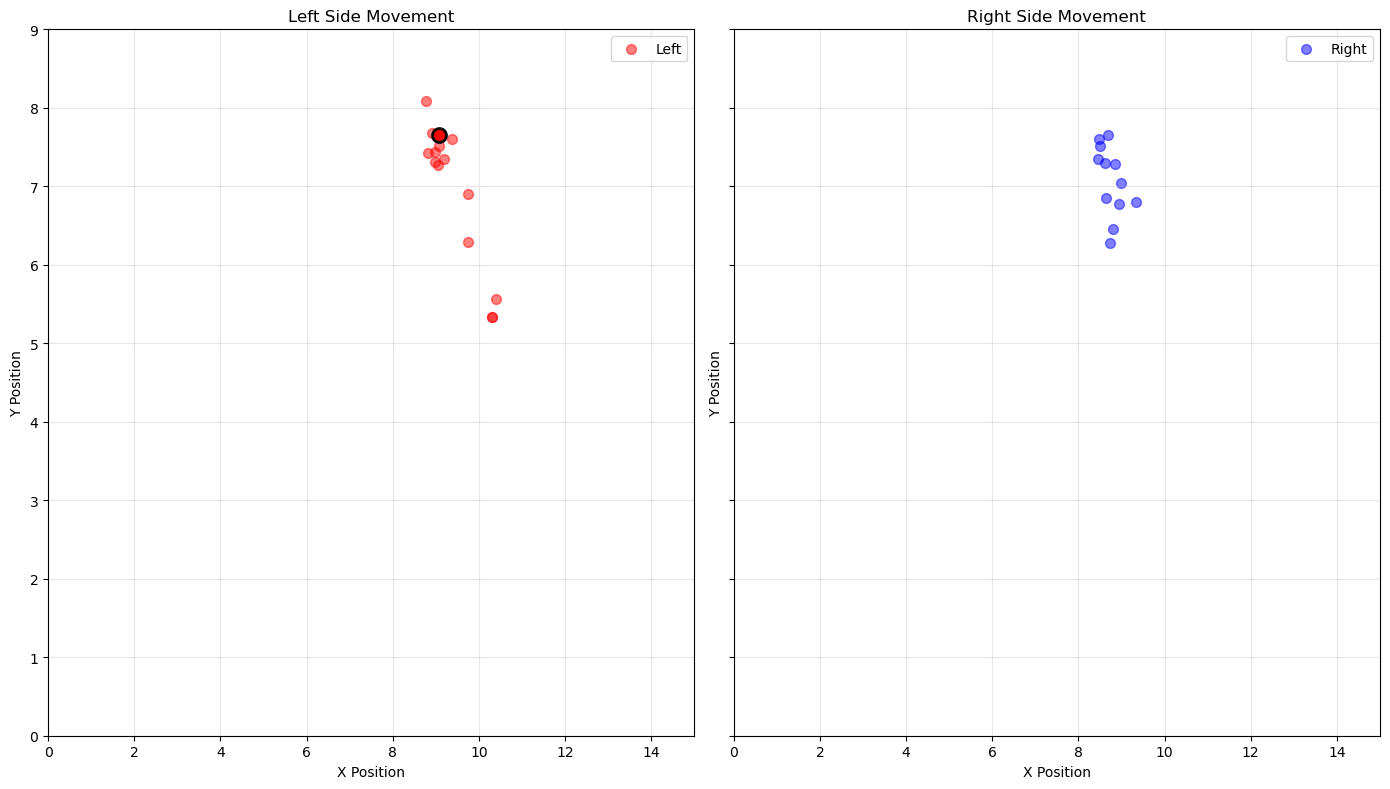

In [ ]:
# The charts have right and left side data points animated in different subplots
def separate_animation(subject_data):
    import matplotlib.pyplot as plt
    from IPython.display import clear_output, display
    import time

    data_sorted = subject_data.sort_values('TIME').reset_index(drop=True)
    step = 1

    # Set up plot
    fig, axs = plt.subplots(1, 2, figsize=(14, 8), sharex=True, sharey=True)

    for i in range(0, len(data_sorted), step):
        clear_output(wait=True)

        # Clear previous plots
        for ax in axs:
            ax.clear()
            ax.set_xlim(0, 15)
            ax.set_ylim(0, 9)
            ax.set_xlabel('X Position')
            ax.set_ylabel('Y Position')
            ax.grid(True, alpha=0.3)

        current_data = data_sorted.iloc[:i+1]

        # Left
        left_data = current_data[current_data['side'] == 'left']
        axs[0].scatter(left_data['X'], left_data['Y'], c='red', s=50, alpha=0.5, label='Left')
        if not current_data.empty and current_data.iloc[-1]['side'] == 'left':
            point = current_data.iloc[-1]
            axs[0].scatter(point['X'], point['Y'], c='red', s=100, edgecolors='black', linewidth=2, marker='o')
        axs[0].legend()
        axs[0].set_title(f'Left Side Movement')

        # Right
        right_data = current_data[current_data['side'] == 'right']
        axs[1].scatter(right_data['X'], right_data['Y'], c='blue', s=50, alpha=0.5, label='Right')
        if not current_data.empty and current_data.iloc[-1]['side'] == 'right':
            point = current_data.iloc[-1]
            axs[1].scatter(point['X'], point['Y'], c='blue', s=100, edgecolors='black', linewidth=2, marker='o')
        axs[1].legend()
        axs[1].set_title(f'Right Side Movement')

        plt.tight_layout()
        display(fig)
        time.sleep(0.05)

separate_animation(subject_data) 

make third subplot of estimated routes
visualize the certainty of the movements and angle range

KeyboardInterrupt: 

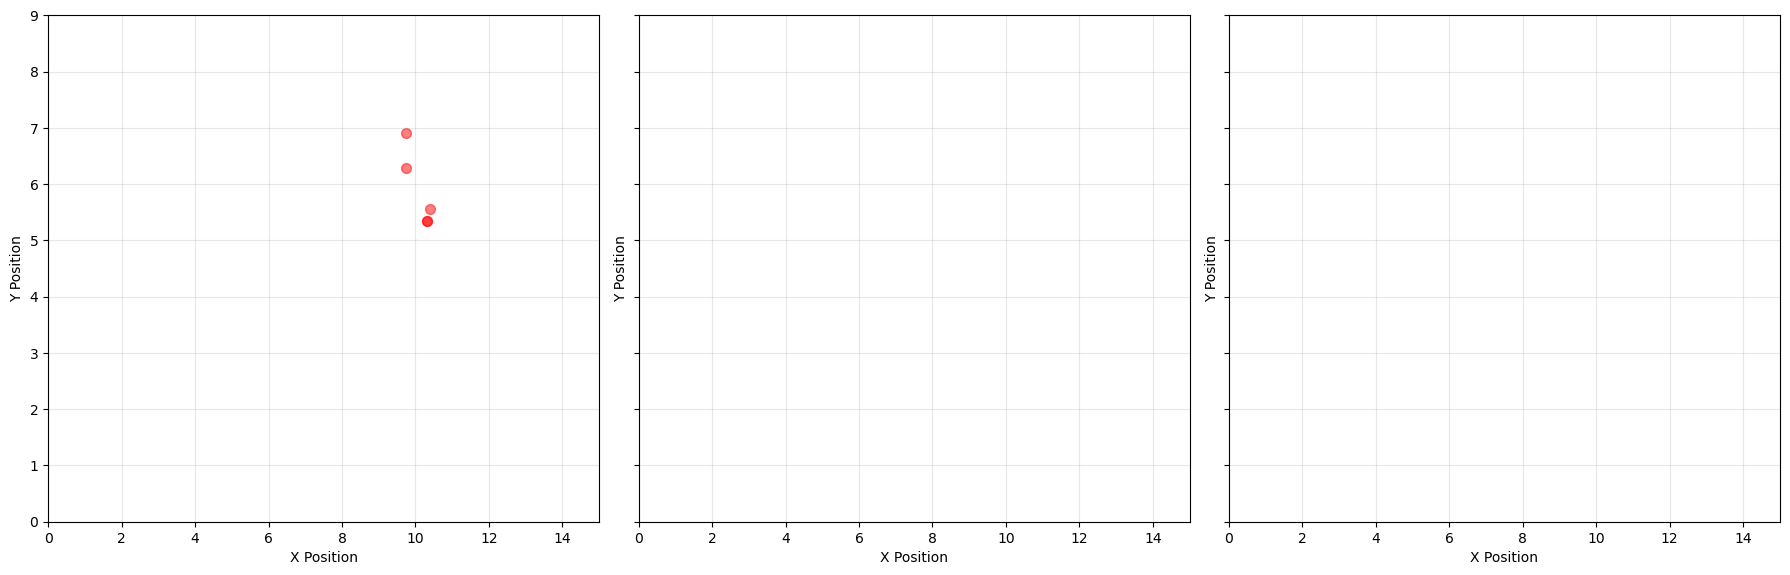

In [ ]:
# The charts with EKF smoothed trajectory additionally
def separate_animation_with_ekf(subject_data, final_params=[0.06787, 0.08011, 0.04829, 0.38712, 0.41107], dt_virt=0.5):
    import matplotlib.pyplot as plt
    from IPython.display import clear_output, display
    import time
    import numpy as np
    import pandas as pd

    s_smooth = compute_smoothed_trajectory(subject_data, final_params, dt_virt)
    
    subject_data_processed = subject_data.copy()
    subject_data_processed['TIME'] = pd.to_datetime(subject_data_processed['TIME'])
    t0 = subject_data_processed['TIME'].min()
    subject_data_processed['timestamp'] = (subject_data_processed['TIME'] - t0).dt.total_seconds()
    
    timestamps = subject_data_processed['timestamp'].values
    virtual_ts = np.arange(min(timestamps), max(timestamps), dt_virt)
    
    data_sorted = subject_data.sort_values('TIME').reset_index(drop=True)
    
    fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharex=True, sharey=True)
    
    step = 1
    
    for i in range(0, len(data_sorted), step):
        clear_output(wait=True)
        
        # Clear previous plots
        for ax in axs:
            ax.clear()
            ax.set_xlim(0, 15)
            ax.set_ylim(0, 9)
            ax.set_xlabel('X Position')
            ax.set_ylabel('Y Position')
            ax.grid(True, alpha=0.3)
        
        current_data = data_sorted.iloc[:i+1]
        current_time = current_data.iloc[-1]['TIME'] if not current_data.empty else data_sorted.iloc[0]['TIME']
        
        # Convert current time to timestamp for EKF indexing
        current_timestamp = (pd.to_datetime(current_time) - t0).total_seconds()
        
        # Left sensor plot
        left_data = current_data[current_data['side'] == 'left']
        axs[0].scatter(left_data['X'], left_data['Y'], c='red', s=50, alpha=0.5, label='Left')
        if not current_data.empty and current_data.iloc[-1]['side'] == 'left':
            point = current_data.iloc[-1]
            axs[0].scatter(point['X'], point['Y'], c='red', s=100, edgecolors='black', linewidth=2, marker='o')
        axs[0].legend()
        axs[0].set_title('Left Side Movement')
        
        # Right sensor plot
        right_data = current_data[current_data['side'] == 'right']
        axs[1].scatter(right_data['X'], right_data['Y'], c='blue', s=50, alpha=0.5, label='Right')
        if not current_data.empty and current_data.iloc[-1]['side'] == 'right':
            point = current_data.iloc[-1]
            axs[1].scatter(point['X'], point['Y'], c='blue', s=100, edgecolors='black', linewidth=2, marker='o')
        axs[1].legend()
        axs[1].set_title('Right Side Movement')
        
        # EKF smoothed trajectory plot
        ekf_idx = np.searchsorted(virtual_ts, current_timestamp)
        ekf_idx = min(ekf_idx, len(s_smooth) - 1)  # Ensure we don't go out of bounds
        
        if ekf_idx > 0:
            # Plot the trajectory up to current time
            x_coords = [s[0] for s in s_smooth[:ekf_idx+1]]
            y_coords = [s[1] for s in s_smooth[:ekf_idx+1]]
            
            axs[2].plot(x_coords, y_coords, 'g-', alpha=0.7, linewidth=2, label='EKF Trajectory')
            
            # Highlight current position
            if ekf_idx < len(s_smooth):
                current_x, current_y = s_smooth[ekf_idx][0], s_smooth[ekf_idx][1]
                axs[2].scatter(current_x, current_y, c='green', s=100, 
                              edgecolors='black', linewidth=2, marker='o', zorder=5)
            
            # Also show the raw sensor data for context
            axs[2].scatter(left_data['X'], left_data['Y'], c='red', s=20, alpha=0.3, label='Left Sensor')
            axs[2].scatter(right_data['X'], right_data['Y'], c='blue', s=20, alpha=0.3, label='Right Sensor')
        
        axs[2].legend()
        axs[2].set_title('EKF Smoothed Trajectory')
        
        plt.tight_layout()
        display(fig)
        time.sleep(0.01)


final_params = [0.06787, 0.08011, 0.04829, 0.38712, 0.41107]
ekf_result = compute_smoothed_trajectory(subject_data.copy(), final_params)
separate_animation_with_ekf(subject_data)

KeyboardInterrupt: 

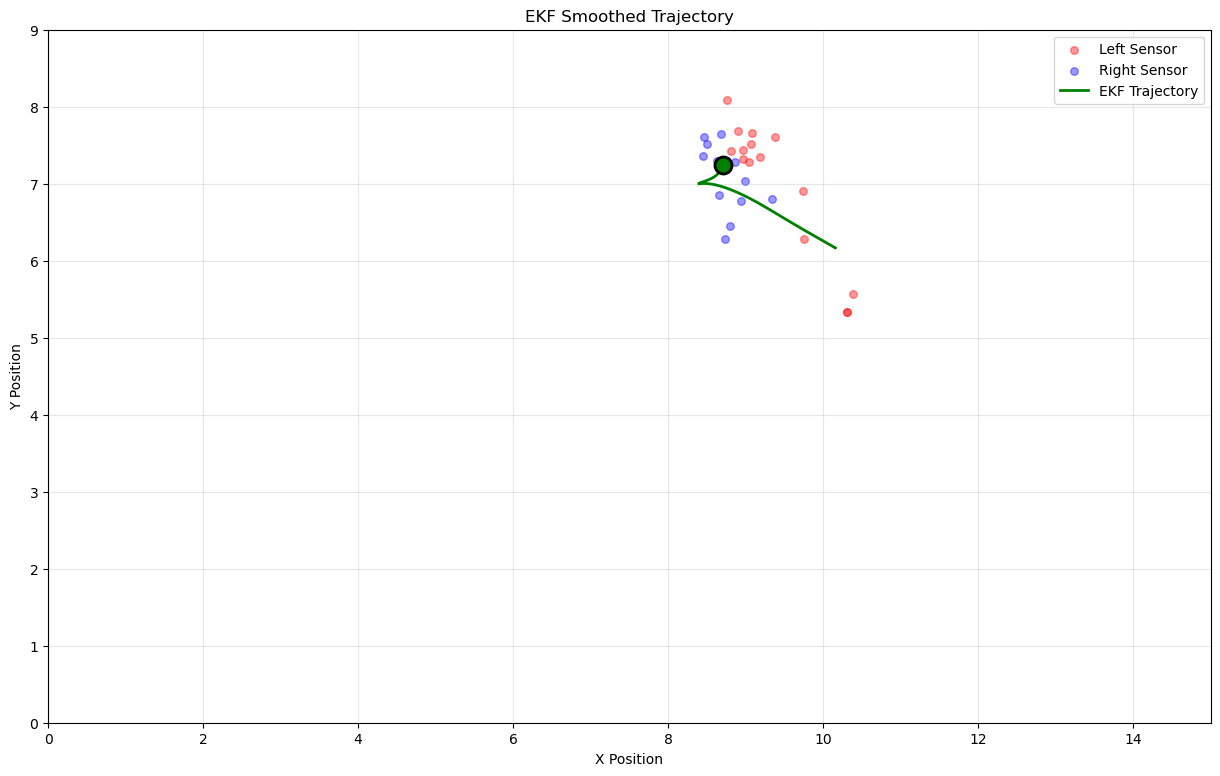

In [ ]:
# The chart only has the EKF smoothed trajectory
def ekf_trajectory_animation(subject_data, final_params=[0.06787, 0.08011, 0.04829, 0.38712, 0.41107], dt_virt=0.5):
    import matplotlib.pyplot as plt
    from IPython.display import clear_output, display
    import time
    import numpy as np
    import pandas as pd
    
    # Compute the smoothed trajectory using the existing function
    s_smooth = compute_smoothed_trajectory(subject_data, final_params, dt_virt)
    
    # Create timestamps for the smoothed trajectory
    subject_data_processed = subject_data.copy()
    subject_data_processed['TIME'] = pd.to_datetime(subject_data_processed['TIME'])
    t0 = subject_data_processed['TIME'].min()
    subject_data_processed['timestamp'] = (subject_data_processed['TIME'] - t0).dt.total_seconds()
    
    # Get the time range for virtual timestamps
    timestamps = subject_data_processed['timestamp'].values
    virtual_ts = np.arange(min(timestamps), max(timestamps), dt_virt)
    
    # Sort the original data by time for synchronization
    data_sorted = subject_data.sort_values('TIME').reset_index(drop=True)
    
    # Set up single plot
    fig, ax = plt.subplots(figsize=(15, 9))
    
    step = 1
    
    # Animation loop
    for i in range(0, len(data_sorted), step):
        clear_output(wait=True)
        
        # Clear previous plot
        ax.clear()
        ax.set_xlim(0, 15)
        ax.set_ylim(0, 9)
        ax.set_xlabel('X Position')
        ax.set_ylabel('Y Position')
        ax.grid(True, alpha=0.3)
        ax.set_title('EKF Smoothed Trajectory')
        
        current_data = data_sorted.iloc[:i+1]
        current_time = current_data.iloc[-1]['TIME'] if not current_data.empty else data_sorted.iloc[0]['TIME']
        
        # Convert current time to timestamp for EKF indexing
        current_timestamp = (pd.to_datetime(current_time) - t0).total_seconds()
        
        # Find the corresponding index in the smoothed trajectory
        ekf_idx = np.searchsorted(virtual_ts, current_timestamp)
        ekf_idx = min(ekf_idx, len(s_smooth) - 1)
        
        # Show raw sensor data up to current time
        left_data = current_data[current_data['side'] == 'left']
        right_data = current_data[current_data['side'] == 'right']
        
        ax.scatter(left_data['X'], left_data['Y'], c='red', s=30, alpha=0.4, label='Left Sensor')
        ax.scatter(right_data['X'], right_data['Y'], c='blue', s=30, alpha=0.4, label='Right Sensor')
        
        if ekf_idx > 0:
            # Plot the trajectory up to current time
            x_coords = [s[0] for s in s_smooth[:ekf_idx+1]]
            y_coords = [s[1] for s in s_smooth[:ekf_idx+1]]
            
            ax.plot(x_coords, y_coords, 'g-', linewidth=2, label='EKF Trajectory')
            
            # Highlight current position
            if ekf_idx < len(s_smooth):
                current_x, current_y = s_smooth[ekf_idx][0], s_smooth[ekf_idx][1]
                ax.scatter(current_x, current_y, c='green', s=150, 
                          edgecolors='black', linewidth=2, marker='o', zorder=5)
        
        ax.legend()
        display(fig)
        time.sleep(0.01)

ekf_trajectory_animation(subject_data)

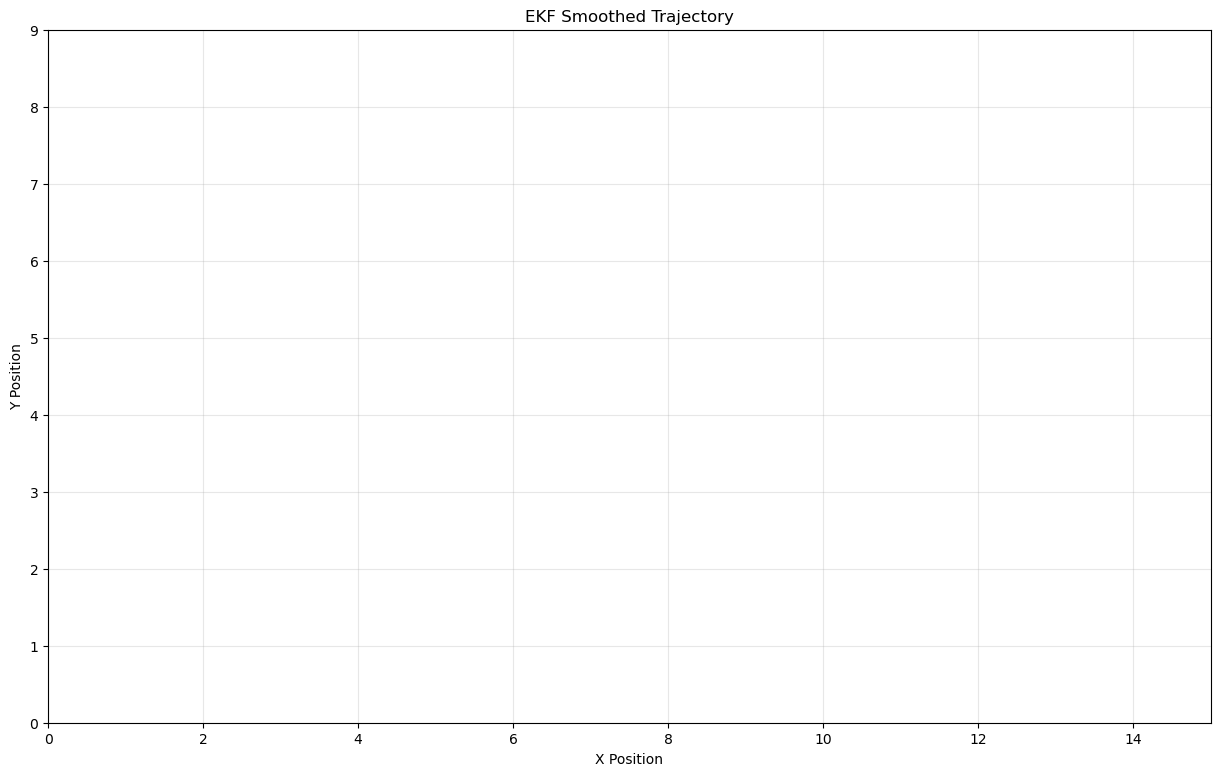

In [ ]:
# The chart with EKF smoothed trajectory only  
### Only function well when save_gif is True 
def ekf_trajectory_animation(subject_data, final_params=[0.06787, 0.08011, 0.04829, 0.38712, 0.41107], dt_virt=0.5, save_gif=False, gif_filename='ekf__animation.gif'):
    import matplotlib.pyplot as plt
    import matplotlib.animation as animation
    import numpy as np
    import pandas as pd
    
    # Compute the smoothed trajectory using the existing function
    s_smooth = compute_smoothed_trajectory(subject_data, final_params, dt_virt)
    
    # Create timestamps for the smoothed trajectory
    subject_data_processed = subject_data.copy()
    subject_data_processed['TIME'] = pd.to_datetime(subject_data_processed['TIME'])
    t0 = subject_data_processed['TIME'].min()
    subject_data_processed['timestamp'] = (subject_data_processed['TIME'] - t0).dt.total_seconds()
    
    # Get the time range for virtual timestamps
    timestamps = subject_data_processed['timestamp'].values
    virtual_ts = np.arange(min(timestamps), max(timestamps), dt_virt)
    
    # Sort the original data by time for synchronization
    data_sorted = subject_data.sort_values('TIME').reset_index(drop=True)
    
    # Set up single plot
    fig, ax = plt.subplots(figsize=(15, 9))
    ax.set_xlim(0, 15)
    ax.set_ylim(0, 9)
    ax.set_xlabel('X Position')
    ax.set_ylabel('Y Position')
    ax.grid(True, alpha=0.3)
    ax.set_title('EKF Smoothed Trajectory')
    
    def animate(frame):
        # Clear previous plot
        ax.clear()
        ax.set_xlim(0, 15)
        ax.set_ylim(0, 9)
        ax.set_xlabel('X Position')
        ax.set_ylabel('Y Position')
        ax.grid(True, alpha=0.3)
        ax.set_title('EKF Smoothed Trajectory')
        
        # Get current data up to this frame
        current_data = data_sorted.iloc[:frame+1]
        
        if current_data.empty:
            return
            
        current_time = current_data.iloc[-1]['TIME']
        
        # Convert current time to timestamp for EKF indexing
        current_timestamp = (pd.to_datetime(current_time) - t0).total_seconds()
        
        # Show raw sensor data up to current time
        left_data = current_data[current_data['side'] == 'left']
        right_data = current_data[current_data['side'] == 'right']
        
        ax.scatter(left_data['X'], left_data['Y'], c='red', s=30, alpha=0.4, label='Left Sensor')
        ax.scatter(right_data['X'], right_data['Y'], c='blue', s=30, alpha=0.4, label='Right Sensor')
        
        # Find the corresponding index in the smoothed trajectory
        ekf_idx = np.searchsorted(virtual_ts, current_timestamp)  
        ekf_idx = min(ekf_idx, len(s_smooth) - 1)
        
        if ekf_idx > 0:
            # Plot the trajectory up to current time
            x_coords = [s[0] for s in s_smooth[:ekf_idx+1]]
            y_coords = [s[1] for s in s_smooth[:ekf_idx+1]]
            
            ax.plot(x_coords, y_coords, 'g-', linewidth=3, label='EKF Trajectory')
            
            # Highlight current position
            if ekf_idx < len(s_smooth):
                current_x, current_y = s_smooth[ekf_idx][0], s_smooth[ekf_idx][1]
                ax.scatter(current_x, current_y, c='green', s=150, 
                          edgecolors='black', linewidth=2, marker='o', zorder=5)
        
        ax.legend()
    
    # Create animation
    step = 1
    frames = range(0, len(data_sorted), step)
    
    ani = animation.FuncAnimation(fig, animate, frames=frames, interval=100, repeat=True)
    
    # Save as GIF if requested
    if save_gif:
        ani.save(gif_filename, writer='pillow', fps=10)
    
    # Show the animation
    plt.show()
    
    return ani

ani = ekf_trajectory_animation(subject_data, save_gif=True)

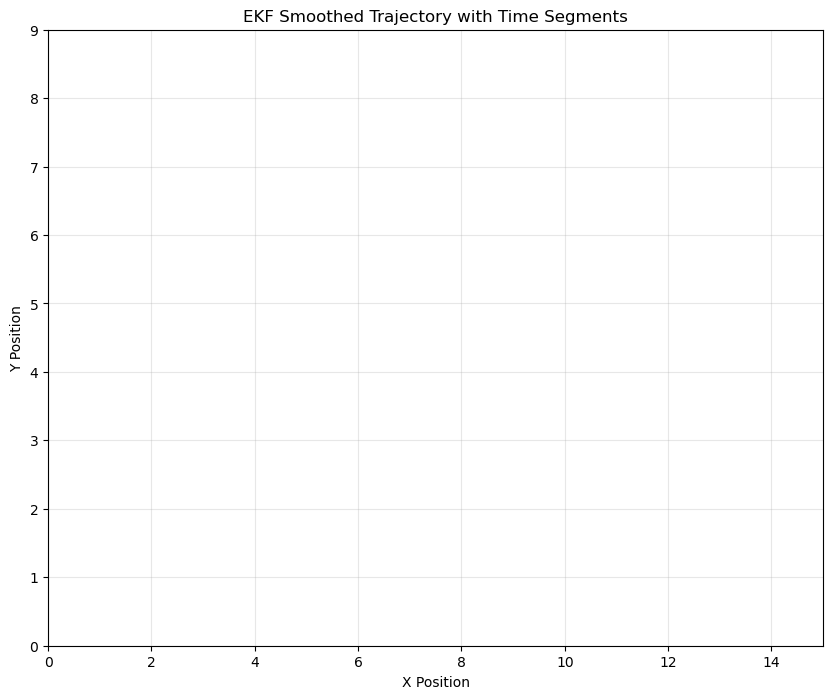

In [6]:
def ekf_trajectory_animation_with_segments(subject_data, final_params=[0.06787, 0.08011, 0.04829, 0.38712, 0.41107], dt_virt=0.5, save_gif=False, gif_filename='ekf_animation.gif'):
    import matplotlib.pyplot as plt
    import matplotlib.animation as animation
    import numpy as np
    import pandas as pd
    
    # Preprocess data like in the original code
    subject_data_processed = subject_data.copy()
    subject_data_processed['TIME'] = pd.to_datetime(subject_data_processed['TIME'])
    t0 = subject_data_processed['TIME'].min()
    subject_data_processed['timestamp'] = (subject_data_processed['TIME'] - t0).dt.total_seconds()
    subject_data_processed['side'] = subject_data_processed['SUBJECTID'].str.extract(r'(\d+[LR])$')[0].str[-1].map({'L': 'left', 'R': 'right'})
    subject_data_processed['timestamp_rounded'] = subject_data_processed['timestamp'].round(3)

    # Create real_data structure
    grouped = subject_data_processed.groupby('timestamp_rounded')
    real_data = []
    for ts, group in grouped:
        entry = {'timestamp': ts}
        left = group[group['side'] == 'left']
        right = group[group['side'] == 'right']
        
        if not left.empty:
            entry['left'] = left[['X', 'Y']].iloc[0].to_numpy()
        if not right.empty:
            entry['right'] = right[['X', 'Y']].iloc[0].to_numpy()
        
        if 'left' in entry and 'right' in entry:
            entry['observed'] = 'both'
            entry['obs'] = np.concatenate([entry['left'], entry['right']])
        elif 'left' in entry:
            entry['observed'] = 'left'
            entry['obs'] = entry['left']
        elif 'right' in entry:
            entry['observed'] = 'right'
            entry['obs'] = entry['right']
        else:
            entry['observed'] = 'none'
            entry['obs'] = np.array([])
        real_data.append(entry)

    # Segment identification (like in original code)
    df = pd.DataFrame(real_data).sort_values('timestamp')
    df['time_diff'] = df['timestamp'].diff()
    gaps = df[df['time_diff'] > 15.0]
    
    segments = []
    current_start = df['timestamp'].iloc[0]
    
    for _, row in gaps.iterrows():
        end = row['timestamp'] - row['time_diff']
        segment_data = df[(df['timestamp'] >= current_start) & (df['timestamp'] <= end)]
        segments.append({'start': current_start, 'end': end, 'duration': end - current_start, 'num_points': len(segment_data)})
        current_start = row['timestamp']
    
    final_segment = df[(df['timestamp'] >= current_start)]
    segments.append({'start': current_start, 'end': df['timestamp'].iloc[-1], 'duration': df['timestamp'].iloc[-1] - current_start, 'num_points': len(final_segment)})
    
    time_segments = []
    for segment in segments:
        seg_data = df[(df['timestamp'] >= segment['start']) & (df['timestamp'] <= segment['end'])].copy()
        time_segments.append({**segment, 'data': seg_data})

    # Compute EKF for each segment
    segment_trajectories = []
    for seg in time_segments:
        run_data = seg['data'].to_dict(orient='records')
        timestamps = [entry['timestamp'] for entry in run_data]
        virtual_ts = np.arange(min(timestamps), max(timestamps), dt_virt).tolist()
        
        try:
            s_filt, P_filt, s_hat, P, _ = ekf_forward(run_data, timestamps, virtual_ts, final_params)
            s_smooth, _ = smoother(s_filt, P_filt, s_hat, P, timestamps, virtual_ts)
            
            segment_trajectories.append({
                'segment': seg,
                'timestamps': virtual_ts,
                'trajectory': s_smooth
            })
        except:
            # Skip segments that fail EKF
            continue
    
    # Sort the original data by time for synchronization
    data_sorted = subject_data.sort_values('TIME').reset_index(drop=True)
    
    # Set up single plot
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.set_xlim(0, 15)
    ax.set_ylim(0, 9)
    ax.set_xlabel('X Position')
    ax.set_ylabel('Y Position')
    ax.grid(True, alpha=0.3)
    ax.set_title('EKF Smoothed Trajectory with Time Segments')
    
    # Define colors for different segments
    colors = ['green', 'purple', 'orange', 'brown', 'pink', 'cyan', 'magenta', 'yellow']
    
    def animate(frame):
        # Clear previous plot
        ax.clear()
        ax.set_xlim(0, 15)
        ax.set_ylim(0, 9)
        ax.set_xlabel('X Position')
        ax.set_ylabel('Y Position')
        ax.grid(True, alpha=0.3)
        ax.set_title('EKF Smoothed Trajectory with Time Segments')
        
        # Get current data up to this frame
        current_data = data_sorted.iloc[:frame+1]
        
        if current_data.empty:
            return
            
        current_time = current_data.iloc[-1]['TIME']
        current_timestamp = (pd.to_datetime(current_time) - t0).total_seconds()
        
        # Show raw sensor data up to current time
        left_data = current_data[current_data['side'] == 'left']
        right_data = current_data[current_data['side'] == 'right']
        
        ax.scatter(left_data['X'], left_data['Y'], c='red', s=30, alpha=0.4, label='Left Sensor')
        ax.scatter(right_data['X'], right_data['Y'], c='blue', s=30, alpha=0.4, label='Right Sensor')
        
        # Plot EKF trajectories for each segment up to current time
        current_position = None
        for i, seg_traj in enumerate(segment_trajectories):
            seg_start = seg_traj['segment']['start']
            seg_end = seg_traj['segment']['end']
            
            # Determine color for this segment
            color = colors[i % len(colors)]
            
            if current_timestamp >= seg_start:
                if current_timestamp <= seg_end:
                    # Current time is within this segment
                    seg_timestamps = np.array(seg_traj['timestamps'])
                    seg_idx = np.searchsorted(seg_timestamps, current_timestamp)
                    seg_idx = min(seg_idx, len(seg_traj['trajectory']) - 1)
                    
                    if seg_idx > 0:
                        # Plot trajectory up to current time in this segment
                        x_coords = [s[0] for s in seg_traj['trajectory'][:seg_idx+1]]
                        y_coords = [s[1] for s in seg_traj['trajectory'][:seg_idx+1]]
                        
                        label = f'EKF Segment {i+1}' if i == 0 else None
                        ax.plot(x_coords, y_coords, color=color, linewidth=3, alpha=0.8, label=label)
                        
                        # Set current position
                        if seg_idx < len(seg_traj['trajectory']):
                            current_position = (seg_traj['trajectory'][seg_idx][0], seg_traj['trajectory'][seg_idx][1])
                    
                elif current_timestamp > seg_end:
                    # Current time is past this segment, show complete segment
                    x_coords = [s[0] for s in seg_traj['trajectory']]
                    y_coords = [s[1] for s in seg_traj['trajectory']]
                    
                    label = f'EKF Segment {i+1}' if i == 0 else None
                    ax.plot(x_coords, y_coords, color=color, linewidth=3, alpha=0.8, label=label)
        
        # Highlight current position
        if current_position:
            ax.scatter(current_position[0], current_position[1], c='black', s=150, 
                      edgecolors='white', linewidth=2, marker='o', zorder=5, label='Current Position')
        
        ax.legend()
    
    # Create animation
    step = 5  # You can adjust this to control animation speed
    frames = range(0, len(data_sorted), step)
    
    ani = animation.FuncAnimation(fig, animate, frames=frames, interval=100, repeat=True)
    
    # Save as GIF if requested
    if save_gif:
        print(f"Saving animation as {gif_filename}...")
        ani.save(gif_filename, writer='pillow', fps=10)
        print(f"Animation saved as {gif_filename}")
    
    # Show the animation
    plt.show()
    
    return ani

# Usage examples:
ani = ekf_trajectory_animation_with_segments(subject_data)
# ani = ekf_trajectory_animation_with_segments(subject_data, save_gif=True, gif_filename='ekf_segments.gif')